In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
#data
dataset = pd.read_csv('/home/kate/data/ClaimPrediction/fdata_v1_encd.csv', index_col=None)
target_column = 'hasclaim'

In [3]:
featureset=[
'acci_last_infractionage',
'carpoolind_encd',
'classcd_encd',
'driverage',
'drivernumber',
'estimatedannualdistance',
'gooddriverind_encd',
'maritalstatuscd_encd',
'mvrstatus_encd',
'mvrstatusage',
'ratingvalue',
'vehbodytypecd_encd',
'vehicleage',
'vehnumber',
'licenseage',
'gendercd_encd'
]
#add calculated column
dataset['licenseage']=dataset['driverage']-dataset['havelicenseage']

In [4]:
featureset_extended=[
'acci_last_infractionage',
'carpoolind_encd',
'classcd_encd',
'driverage',
'drivernumber',
'estimatedannualdistance',
'gooddriverind_encd',
'maritalstatuscd_encd',
'mvrstatus_encd',
'mvrstatusage',
'ratingvalue',
'vehbodytypecd_encd',
'vehicleage',
'vehnumber',
'licenseage',
'gendercd_encd',
'external_length_in',
'external_width_in'
]

In [5]:
#models files dir
ModelsDir='/home/kate/Models/XGB/'

In [6]:
import glob
ModelsList=glob.glob('%s*.model_licenseage_gender'%ModelsDir)
ModelsList_Extended=glob.glob('%s*.model_with_all'%ModelsDir)

In [7]:
#xgb library
import xgboost as xgb

In [8]:
#Evaluation metric to be used in tuning
from sklearn.metrics import roc_auc_score,confusion_matrix,roc_curve,auc
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y)) ], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)
def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

In [9]:
#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
def ROCCurves (Actual, Predicted):
    '''
    Plot ROC curves for the multiclass problem
    based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Actual.values, Predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])


    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes
    
    return fpr[1],tpr[1],roc_auc[1]


def plotROCCurves (fpr1,tpr1,roc_auc1,label1,fpr2,tpr2,roc_auc2,label2):
        # Plot all ROC curves
    plt.figure()
    plt.plot(fpr1, tpr1, label=label1.format(roc_auc1))
    plt.plot(fpr2, tpr2, label=label2.format(roc_auc2))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")

In [10]:
#splitting to train/test 
from sklearn.model_selection import train_test_split
X, X_test, y, y_test = train_test_split(dataset.loc[:,featureset], dataset[target_column], test_size=0.2, random_state=42)

In [11]:
#prediction dataframes
y_pred_test=pd.DataFrame(index=y_test.index)
y_pred_test[target_column]=0
kfold = 10

for xgb_model_file in ModelsList:
    print(xgb_model_file)
    #load saved model
    xgb_model = pickle.load(open(xgb_model_file, 'rb'))
    #prediction
    d_test=xgb.DMatrix(X_test.values)
    y_pred_test[target_column] +=  xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
    


/home/kate/Models/XGB/m_9.model_licenseage_gender
/home/kate/Models/XGB/m_5.model_licenseage_gender
/home/kate/Models/XGB/m_0.model_licenseage_gender
/home/kate/Models/XGB/m_2.model_licenseage_gender
/home/kate/Models/XGB/m_3.model_licenseage_gender
/home/kate/Models/XGB/m_1.model_licenseage_gender
/home/kate/Models/XGB/m_6.model_licenseage_gender
/home/kate/Models/XGB/m_4.model_licenseage_gender
/home/kate/Models/XGB/m_7.model_licenseage_gender
/home/kate/Models/XGB/m_8.model_licenseage_gender


In [12]:
#Extended
X, X_test, y, y_test = train_test_split(dataset.loc[:,featureset_extended], dataset[target_column], test_size=0.2, random_state=42)

In [13]:
#prediction dataframes
y_pred_test_extended=pd.DataFrame(index=y_test.index)
y_pred_test_extended[target_column]=0
kfold = 10

for xgb_model_file in ModelsList_Extended:
    print(xgb_model_file)
    #load saved model
    xgb_model = pickle.load(open(xgb_model_file, 'rb'))
    #prediction
    d_test=xgb.DMatrix(X_test.values)
    y_pred_test_extended[target_column] +=  xgb_model.predict(d_test, ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)

/home/kate/Models/XGB/m_3.model_with_all
/home/kate/Models/XGB/m_7.model_with_all
/home/kate/Models/XGB/m_0.model_with_all
/home/kate/Models/XGB/m_1.model_with_all
/home/kate/Models/XGB/m_8.model_with_all
/home/kate/Models/XGB/m_6.model_with_all
/home/kate/Models/XGB/m_5.model_with_all
/home/kate/Models/XGB/m_2.model_with_all
/home/kate/Models/XGB/m_9.model_with_all
/home/kate/Models/XGB/m_4.model_with_all


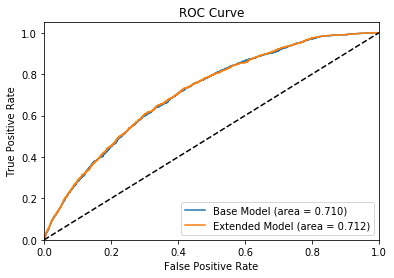

In [19]:
fpr1,tpr1,roc_auc1=ROCCurves (y_test, y_pred_test)
label1='Base Model (area = {0:0.3f})'
fpr2,tpr2,roc_auc2=ROCCurves (y_test, y_pred_test_extended)
label2='Extended Model (area = {0:0.3f})'
plotROCCurves(fpr1,tpr1,roc_auc1,label1,fpr2,tpr2,roc_auc2,label2)